In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import cPickle as pickle
from pyDOE import lhs as latin_hyper_cube
from adaptive_path_estimator import PathEstimator
from smc.utils import ProgressBar
%matplotlib inline

In [2]:
def _normal_potential(samples, design, D):
    """ computes the energy of the samples for the normal model"""
    
    t, beta = design.T
    U_t = (samples*D -D**2/2.0) *beta[:, None, None]
    U_beta = samples*D*t[:, None, None] - samples**2/2.0 - D**2*t[:, None, None]/2.0

    return np.vstack([U_t.T, U_beta.T]).T

In [3]:
D = 10.0**3
K = 10
N = 100
cutoff = 1.0/D**2 #0.03
dimension = 2

# choose a series of design points
n_grid = np.ceil(np.log(D)*2).astype(int)
design = np.array(np.meshgrid(np.linspace(0,1,n_grid), np.linspace(cutoff, 1, n_grid))).reshape(2,-1).T

# samples (draw them)
np.random.seed(1337)
samples = np.array([stats.norm(loc=D*t, scale = beta**-0.5).rvs((N,1)) for t, beta in design])

potential = lambda x, y: _normal_potential(x, y, D=D)

In [ ]:
PathEstimator._potential

In [18]:
est = PathEstimator(potential, dimension, [0.0, cutoff], [1.0,1.0], ['linear','linear'])
est._fit_energy(samples, design)

ts = np.linspace(0,1,100)
betas = np.linspace(cutoff*2,1,101)[1:]
params = np.array(np.meshgrid(ts, betas)).reshape(2,-1).T
predictions = est.predict_energy(params)


Fitting GP #0
Optimization restart 1/10, f = 99.7083367517
Optimization restart 2/10, f = 99.7083367285
Optimization restart 3/10, f = 99.7083367281
Optimization restart 4/10, f = 99.7083367331
Optimization restart 5/10, f = 99.708336734
Optimization restart 6/10, f = 99.7083367291
Optimization restart 7/10, f = 99.7083367273
Optimization restart 8/10, f = 99.7083367449
Optimization restart 9/10, f = 99.7083367261
Optimization restart 10/10, f = 99.7083367279

Fitting GP #1
Optimization restart 1/10, f = 3392.32753439
Optimization restart 2/10, f = 3278.32275041
Optimization restart 3/10, f = 3321.9226184
Optimization restart 4/10, f = 3254.27976691
Optimization restart 5/10, f = 3378.86197931
Optimization restart 6/10, f = 3315.19932593
Optimization restart 7/10, f = 3203.90447185
Optimization restart 8/10, f = 3363.65364571
Optimization restart 9/10, f = 3179.58524352
Optimization restart 10/10, f = 3398.49146387

Fitting GP #2
Optimization restart 1/10, f = 251.13955847
Optimizatio

### Plot the comparisions

In [20]:
D

1000.0

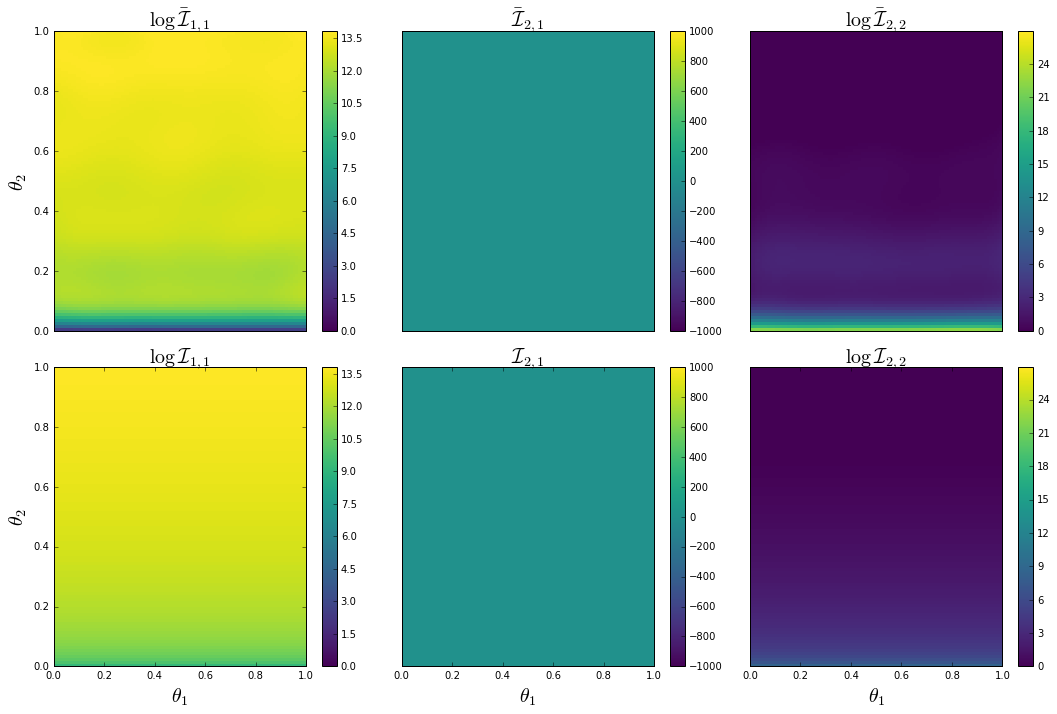

In [19]:
plt.rcParams['figure.figsize'] = 15, 10
cmap = plt.cm.viridis

# Compute the true values
grid = np.array(np.meshgrid(ts, betas))
energy_t = grid[1]*D**2
energy_beta = 0.5/grid[1]**2

# Compute the estimated values
est_energy_t = predictions[:,0,0].reshape(100,100)
est_energy_beta = predictions[:,1,1].reshape(100,100)
est_energy_cov = predictions[:,1,0].reshape(100,100)

# Plot the estimated values
plt.subplot(231)
plt.pcolor(np.log(est_energy_t), vmin=0, vmax=np.log(D**2+D), cmap=cmap)
plt.colorbar()
plt.title(r'$\log\,\bar{\mathcal{I}}_{1,1}$', fontsize=20)
plt.yticks(np.linspace(0,100,6), np.linspace(0,1,6))
plt.ylabel(r'$\theta_2$', fontsize=20)
plt.xticks([],[])

plt.subplot(232)
plt.pcolor(est_energy_cov, vmin=-D, vmax = D, cmap=cmap)
plt.colorbar() 
plt.title(r'$\bar{\mathcal{I}}_{2,1}$', fontsize=20)
plt.xticks([],[])
plt.yticks([],[])

plt.subplot(233)
plt.pcolor(np.log(est_energy_beta), vmin=0.0, vmax = np.log(0.5*cutoff**-2), cmap=cmap)
plt.colorbar()
plt.title(r'$\log\,\bar{\mathcal{I}}_{2,2}$', fontsize=20)
plt.xticks([],[])
plt.yticks([],[])

# Plot the true values
plt.subplot(234)
plt.pcolor(np.log(energy_t), vmin=0, vmax=np.log(D**2+D), cmap=cmap)
plt.colorbar()
plt.title(r'$\log\,\mathcal{I}_{1,1}$', fontsize=20)
plt.yticks(np.linspace(0,100,6), np.linspace(0,1,6))
plt.ylabel(r'$\theta_2$', fontsize=20)
plt.xticks(np.linspace(0,100,6), np.linspace(0,1,6))
plt.xlabel(r'$\theta_1$', fontsize=20)

# Plot the true values
plt.subplot(235)
plt.pcolor(np.zeros_like(est_energy_cov), vmin=-D, vmax = D, cmap=cmap)
plt.colorbar() 
plt.title(r'$\mathcal{I}_{2,1}$', fontsize=20)
plt.xticks(np.linspace(0,100,6), np.linspace(0,1,6))
plt.yticks([],[])
plt.xlabel(r'$\theta_1$', fontsize=20)

plt.subplot(236)
plt.pcolor(np.log(energy_beta), vmin=0.0, vmax = np.log(0.5*cutoff**-2), cmap=cmap)
plt.colorbar()
plt.title(r'$\log\,\mathcal{I}_{2,2}$', fontsize=20)
plt.xticks(np.linspace(0,100,6), np.linspace(0,1,6))
plt.yticks([],[])
plt.xlabel(r'$\theta_1$', fontsize=20)

plt.tight_layout()
plt.savefig('demos/normal/plots/example_manifold_D{}.png'.format(np.int(D)))

### Path exploration

In [24]:
D = 10.0
M = 500
N = 100
K = 5
offset = 0.2

In [25]:
np.random.seed(1339)
cutoff = 1.0/D**2
dimension = 2

grid_sizes = [51, 51]
directions = ['forward', 'both']
max_strides= [20,20]

# choose a series of design points
n_grid = np.ceil(np.log(D)*2).astype(int)
design = np.array(np.meshgrid(np.linspace(0,1,n_grid), np.linspace(cutoff, 1, n_grid))).reshape(2,-1).T

potential = lambda x, y: _normal_potential(x, y, D=D)

est = PathEstimator(potential, dimension, [0.0, cutoff], [1.0,1.0], ['linear','log_decreasing'])

#
paths = []
pb = ProgressBar(M)
for m in range(M):
    
    # Sample
    samples = np.array([stats.norm(loc=D*t, scale = beta**-0.5).rvs((N,1)) for t, beta in design])
    
    # Fit model
    est._fit_energy(samples, design, verbose=False)
    est.generate_weighted_graph(grid_sizes, directions, max_strides, offset=offset)
    
    # Shortest path
    paths.append(est.shortest_path((0.0,1.0), (1.0, 1.0), 1))
    pb.increment()
pb.finish()

% complete:  1 4 7 10 13 16 19 22 25 28 31 34 37 40 43 46 49 52 55 58 61 64 67 70 73 76 79 82 85 88 91 94 97 100 
Elapsed time: 6070.6 seconds.


In [13]:
from networkx import all_simple_paths

In [51]:
count

166963878

In [14]:
count=0
for path in all_simple_paths(est.graph, (0.0,1.0), (1.0,1.0)):
    count+=1
print count

KeyboardInterrupt: 

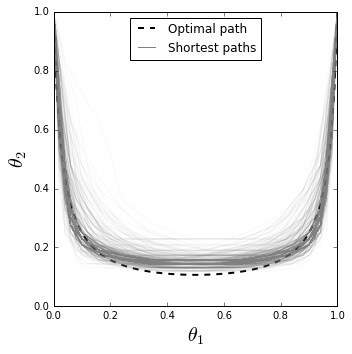

In [31]:
plt.rcParams['figure.figsize'] = 5,5

# plot the true path
ts = np.linspace(0,1,100)
mus = ts*D
sigmas2 = (3+D**2/4.0 - (mus - D/2.0)**2)/3.0
betas = 1/sigmas2

plt.plot(ts, betas, color='black', ls='--', lw=2, label='Optimal path')

for path in paths:
    plt.plot(path[:,0], path[:,1], color='grey', alpha=0.05)
    
    
plt.plot([-2,-3], [0,1], color='grey', label='Shortest paths')    

plt.ylim(0,1)
plt.xlim(0,1)
plt.ylabel(r'$\theta_2$', fontsize=20)
plt.xlabel(r'$\theta_1$', fontsize=20)

plt.legend(loc='upper center')

plt.tight_layout()
plt.savefig('demos/normal/plots/sample_paths_D{}_alpha{}.png'.format(D, offset))

## Some stuff for tables

In [32]:
Ds = [10.0, 100.0, 1000.0, 10000.0]
M = 500
L = 1
N = 100
K = 5
offset = 0.2

In [33]:
np.random.seed(1339)
cutoff = 1.0/D**2
dimension = 2

grid_sizes = [50, 50]
directions = ['forward', 'both']
max_strides= [20,20]

design = np.array(np.meshgrid(np.linspace(0,1,K), np.linspace(cutoff, 1, K))).reshape(2,-1).T

#
estimates = {}
path_lens = {}
pb = ProgressBar(M*len(Ds)*L)

# Try lots of Ds
for D in Ds:
    potential = lambda x, y: _normal_potential(x, y, D=D)
    est = PathEstimator(potential, dimension, [0.0, cutoff], [1.0,1.0], ['linear','linear'])
    estimates[D]=[]
    path_lens[D]=[]
    
    # Try it lots of times
    for m in range(M):

        # Sample
        samples = np.array([stats.norm(loc=D*t, scale = beta**-0.5).rvs((N,1)) for t, beta in design])

        # Fit model
        est._fit_energy(samples, design, verbose=False)
        est.generate_weighted_graph(grid_sizes, directions, max_strides, offset=offset)

        # Shortest path
        path = est.shortest_path((0.0,1.0), (1.0, 1.0), 2*np.log(D).astype('int'))
        path_lens[D].append(len(path))

        for l in range(L):
            samples = np.array([stats.norm(loc=D*t, scale = beta**-0.5).rvs((N,1)) for t, beta in path])
            estimates[D].append(est.estimate_lambda(samples, path))    
            pb.increment()
            
pb.finish()

% complete:  1 4 7 10 13 16 19 22 25 28 31 34 37 40 43 46 49 52 55 58 61 64 67 70 73 76 79 82 85 88 91 94 97 
Elapsed time: 22633.7 seconds.


In [50]:
fname = 'demos/normal/output/estimates_shortest_{}.pkl'.format(M)


In [41]:
for key, values in estimates.iteritems():
    
    print 'D = {}'.format(key)
    print '-----------------------'
    print 'RMSE = {0:.4f}'.format((np.array(values)**2).mean()**0.5)
    print 'Standard Deviation = {0:.3f}'.format(np.array(values).std())
    print '95% CI: ({0:.3f}, {1:.3f})'.format(*np.percentile(values, [5,95]))
    
    print 

D = 1000.0
-----------------------
RMSE = 1.0457
Standard Deviation = 1.045
95% CI: (-1.629, 1.766)

D = 10000.0
-----------------------
RMSE = 7.8437
Standard Deviation = 7.843
95% CI: (-12.726, 13.704)

D = 10.0
-----------------------
RMSE = 0.0757
Standard Deviation = 0.076
95% CI: (-0.129, 0.118)

D = 100.0
-----------------------
RMSE = 0.1817
Standard Deviation = 0.182
95% CI: (-0.291, 0.277)



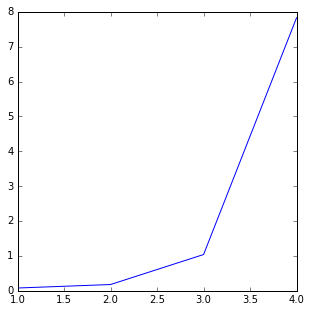

In [44]:
plt.plot([1.0, 2.0, 3.0, 4.0], [0.08, 0.18, 1.04,7.83])

In [34]:
np.random.seed(1339)

#
bad_estimates = {}
pb = ProgressBar(M*len(Ds)*L)

# Try lots of Ds
for D in Ds:
    
    potential = lambda x, y: _normal_potential(x, y, D=D)
    est = PathEstimator(potential, dimension, [0.0, cutoff], [1.0,1.0], ['linear','linear'])
    bad_estimates[D]=[]
    
    # Try it lots of times
    for path_len in path_lens[D]:
            path = np.vstack([np.linspace(0,1,path_len),np.ones(path_len)]).T

            for l in range(L):
                samples = np.array([stats.norm(loc=D*t, scale = beta**-0.5).rvs((N,1)) for t, beta in path])
                bad_estimates[D].append(est.estimate_lambda(samples, path))    
                pb.increment()
            
pb.finish()

% complete:  1 4 7 10 13 16 19 22 25 28 31 34 37 40 43 46 49 52 55 58 61 64 67 70 73 76 79 82 85 88 91 94 97 
Elapsed time: 451.2 seconds.


In [42]:
for key, values in bad_estimates.iteritems():
    
    print 'D = {}'.format(key)
    print '-----------------------'
    print 'RMSE = {0:.4f}'.format((np.array(values)**2).mean()**0.5)
    print 'Standard Deviation = {0:.3f}'.format(np.array(values).std())
    print '95% CI: ({0:.3f}, {1:.3f})'.format(*np.percentile(values, [5,95]))
    
    print 

D = 1000.0
-----------------------
RMSE = 3.8929
Standard Deviation = 3.892
95% CI: (-6.155, 6.081)

D = 10000.0
-----------------------
RMSE = 34.0459
Standard Deviation = 34.033
95% CI: (-60.205, 51.111)

D = 10.0
-----------------------
RMSE = 0.1208
Standard Deviation = 0.121
95% CI: (-0.207, 0.200)

D = 100.0
-----------------------
RMSE = 0.5048
Standard Deviation = 0.505
95% CI: (-0.810, 0.821)

